# 2nd set of exercises

These exercises are designed for those of you that already have experience with ML / deep learning, and want to apply this knowledge to do some interesting NLP applications.

We'll be focusing mostly on word embeddings, with a bit of TF-IDF at the beginning to get your feet wet.

## 0. Requirements

Run the cell below to install dependencies.

In [8]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: gosam 2.1.1-4b98559 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of gosam or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: professor2 X.Y.Z has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of professor2 or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


## 1. A simple search engine

One of the simplest topics that one could choose for showing the popularity and potential of word embeddings is the humble search engine. We'll be vectorizing some documents. You've probably seen this in the first set of exercises, if not, no big deal! You're going to learn how to do it now!

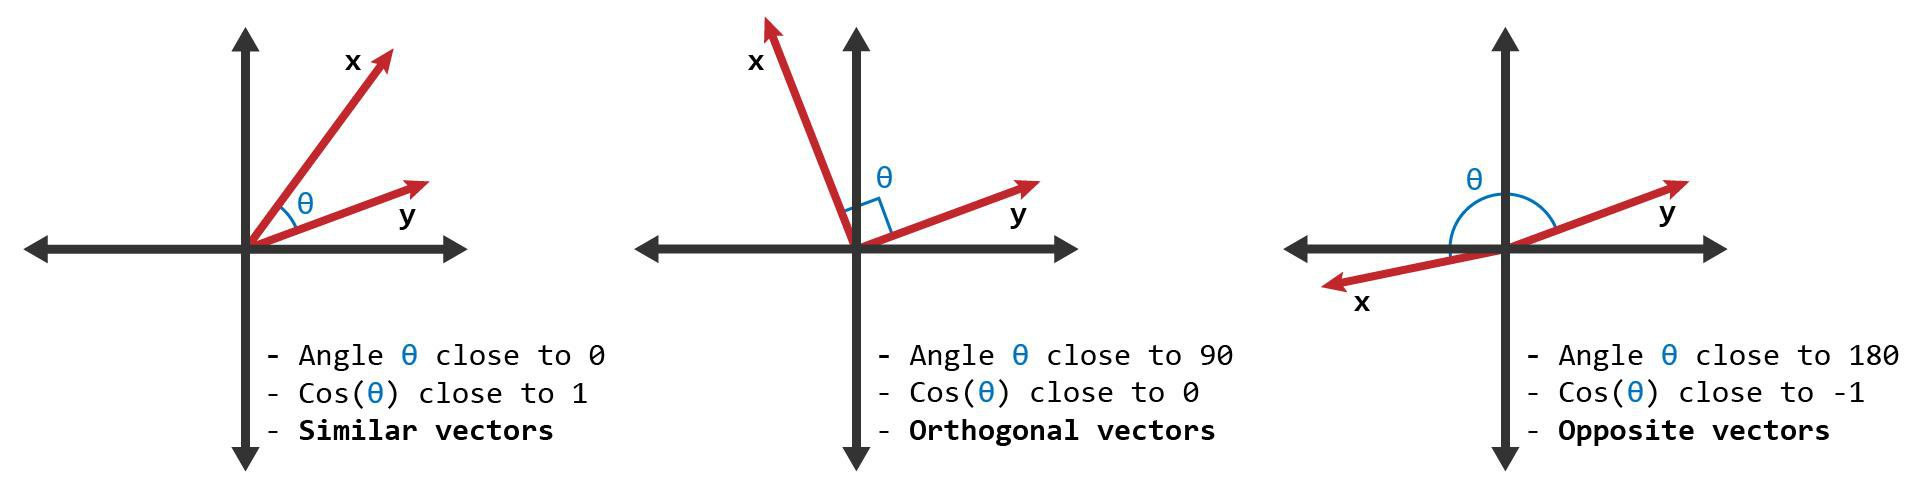

To not go over the nitty-gritty details of the implementation, we'll be using two tools that are already available to us in the scikit-learn package.

```py
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
```

- `TfidfVectorizer` - allows you to train on a corpus of documents, and obtain their TF-IDF representation for future use.
- `cosine_similarity` - utility function that takes two vectors and returns a floating point number between -1 and 1. This is what we'll use to decide which documents are "closer" to the query.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [10]:
class SimpleSearchEngine:
    """
    Initializes itself based on a corpus of documents and allows you to search for the top N documents closer to a query passed in.
    """
    def __init__(self, documents):
        self.documents = documents
        self.vectorizer = TfidfVectorizer()

        # Fit TF-IDF vectorizer on documents
        self.tf_idf_matrix = self.vectorizer.fit_transform(documents)

    def search(self, query, top_n=5):
        # Transform query into TF-IDF representation
        query_vector = self.vectorizer.transform([query])

        # Compute cosine similarity between query and all the documents
        cosine_similarities = cosine_similarity(query_vector, self.tf_idf_matrix).flatten()

        # Get indices of top documents
        top_indices = cosine_similarities.argsort()[-top_n:][::-1]

        # Return top documents
        return [self.documents[i] for i in top_indices]


In [11]:
# Example usage:
documents = [
    "Machine learning is the study of computer algorithms that improve automatically through experience.",
    "Deep learning is a subset of machine learning where artificial neural networks, algorithms inspired by the human brain, learn from large amounts of data.",
    "Natural language processing (NLP) is a field of computer science, artificial intelligence, and computational linguistics concerned with the interactions between computers and human languages.",
    "Reinforcement learning is an area of machine learning concerned with how software agents ought to take actions in an environment in order to maximize some notion of cumulative reward.",
    "Information retrieval is the process of obtaining information from a large source of data, often text-based, and presenting it in a structured format."
]

search_engine = SimpleSearchEngine(documents)

In [12]:
query = "machine learning"
top_results = search_engine.search(query)

print("Top search results:")
for i, result in enumerate(top_results, start=1):
    print(f"{i}. {result}")

Top search results:
1. Deep learning is a subset of machine learning where artificial neural networks, algorithms inspired by the human brain, learn from large amounts of data.
2. Machine learning is the study of computer algorithms that improve automatically through experience.
3. Reinforcement learning is an area of machine learning concerned with how software agents ought to take actions in an environment in order to maximize some notion of cumulative reward.
4. Information retrieval is the process of obtaining information from a large source of data, often text-based, and presenting it in a structured format.
5. Natural language processing (NLP) is a field of computer science, artificial intelligence, and computational linguistics concerned with the interactions between computers and human languages.


In [13]:
assert top_results[0].startswith('Deep learning')
assert top_results[1].startswith('Machine learning')

## 2. Training & visualizing embeddings with deep learning

As we've seen during the course, there are more interesting approaches that capture the meaning of your data, using deep learning techniques (like Word2Vec). In the following exercise we'll be training our own embeddings and then analyze them in the tensorflow projector: https://projector.tensorflow.org

We'll be using tensorflow and Keras in order to be building our solution, so make sure to check out their documentation in case you get stuck!

In [14]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np 

# Model configuration, let's use these as parameters for what we use below
max_sequence_length = 100
num_distinct_words = 10000
embedding_output_dims = 15
loss_function = 'binary_crossentropy'
optimizer = 'adam'
additional_metrics = ['accuracy']
number_of_epochs = 10
verbosity_mode = True
validation_split = 0.20


The dataset: we'll be using the IMDB movies dataset in order to perform sentiment analysis of this data, and learn some embeddings too while we're at it.

In [15]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_distinct_words)
print(x_train.shape)
print(x_test.shape)

(25000,)
(25000,)


In [16]:
print(f'Review: {x_train[0]}')
print(f'Expected prediction: {y_train[0]}')

Review: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
Expected prediction: 1


In [17]:
# Pad all sequences, meaning we're making sequences out of documents so they all get passed in chunks to the algorithm.

padded_inputs = pad_sequences(x_train, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>
padded_inputs_test = pad_sequences(x_test, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>

In [18]:
word_index = imdb.get_word_index()

def build_reverse_word_index(word_to_id):
    INDEX_FROM=3   # word index offset
    word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
    word_to_id["<PAD>"] = 0
    word_to_id["<START>"] = 1
    word_to_id["<UNK>"] = 2
    word_to_id["<UNUSED>"] = 3

    id_to_word = {value:key for key,value in word_to_id.items()}
    return id_to_word

reverse_word_index = build_reverse_word_index(word_index)


In [19]:
# Obtain 3 texts
def translate_vector_to_text(reverse_word_index, padded_inputs):
    return ' '.join(reverse_word_index[id] for id in padded_inputs[i])

for i in np.random.randint(0, len(padded_inputs), 3):
    sentence = translate_vector_to_text(reverse_word_index, padded_inputs)
    print('=================================================')
    print(f'Sample = {i} | Length = {len(padded_inputs[i])}')
    print('=================================================')
    print(sentence)
    print(f'Expected classification: {"negative" if 0 == y_train[i] else "positive"}')

Sample = 362 | Length = 100
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> what another reviewer called lack of character development i call understatement the movie didn't bash one over the head with <UNK> or unnecessary <UNK> yes there were many <UNK> stories that we only got a glimpse of but this was primarily a one day <UNK> into an event that <UNK> change in all of the characters' lives henry <UNK> performance was a really lovely study in the power of acting that focuses on reaction rather than action good rental
Expected classification: positive
Sample = 15172 | Length = 100
again it is a landmark for computer animation imagery highly recommended br br this is what it is br br the <UNK> eye is a spectacular odyssey through time your journey begins at the dawn of creation and moves through the rise of man and technology travel in the world of <UNK> and on into the future with breathtaking computer ani

### Word embeddings

We're going to be using something called Keras Embedding layers, which allow us to abstract away tough parts of our training algorithm and cake layers together in order to build our model.

You can find some docs here: https://keras.io/api/layers/core_layers/embedding/ 


In [20]:
from keras import callbacks

# Create an embedding layer.
model = Sequential(
    [
        Embedding(num_distinct_words, embedding_output_dims, input_length=max_sequence_length),
        Dropout(0.50),
        Conv1D(filters=16, kernel_size=2, padding='same', activation='relu'),
        Dropout(0.50),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dropout(0.50),
        Dense(1, activation='sigmoid')
    ]
)

# Compile model.
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# Train model for one epoch.
# Give a summary
model.summary()

# Train the model
history = model.fit(padded_inputs, y_train, epochs=number_of_epochs,
                    validation_data=(padded_inputs_test, y_test),
                    verbose=verbosity_mode, validation_split=validation_split)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 15)           150000    
                                                                 
 dropout (Dropout)           (None, 100, 15)           0         
                                                                 
 conv1d (Conv1D)             (None, 100, 16)           496       
                                                                 
 dropout_1 (Dropout)         (None, 100, 16)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 50, 16)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                        

2024-03-22 11:26:53.692742: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-22 11:26:53.743133: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-22 11:26:53.743418: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/10


/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-03-22 11:26:58.727707: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-03-22 11:27:00.238464: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3c2c6194c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-22 11:27:00.238524: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-03-22 11:27:00.261349: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-22 11:27:00.50449

782/782 [==============================] - 44s 49ms/step - loss: 0.6734 - accuracy: 0.5597 - val_loss: 0.5367 - val_accuracy: 0.7816
Epoch 2/10
782/782 [==============================] - 9s 11ms/step - loss: 0.4137 - accuracy: 0.8104 - val_loss: 0.3647 - val_accuracy: 0.8452
Epoch 3/10
782/782 [==============================] - 8s 10ms/step - loss: 0.3280 - accuracy: 0.8594 - val_loss: 0.3375 - val_accuracy: 0.8555
Epoch 4/10
782/782 [==============================] - 6s 8ms/step - loss: 0.2941 - accuracy: 0.8769 - val_loss: 0.3402 - val_accuracy: 0.8517
Epoch 5/10
782/782 [==============================] - 7s 9ms/step - loss: 0.2690 - accuracy: 0.8885 - val_loss: 0.3388 - val_accuracy: 0.8477
Epoch 6/10
782/782 [==============================] - 7s 8ms/step - loss: 0.2553 - accuracy: 0.8950 - val_loss: 0.3402 - val_accuracy: 0.8490
Epoch 7/10
782/782 [==============================] - 5s 7ms/step - loss: 0.2459 - accuracy: 0.8980 - val_loss: 0.3501 - val_accuracy: 0.8429
Epoch 8/10
78

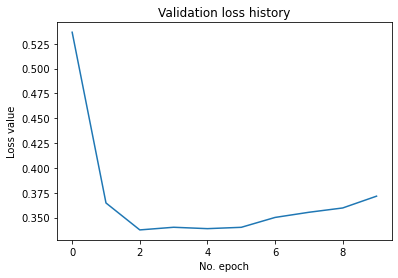

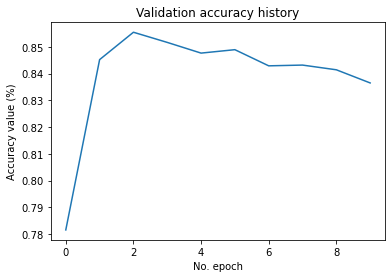

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()

The accuracy and loss look quite funky. That's because we're overfitting from the get go, but that's not necessarily an issue with us as we still have around 84% validation accuracy on the validation data.

## Time to visualize our embeddings!

Now we'll extract the trained embedding layer and associate what it built together with the word index

In [22]:
e = model.layers[0]
weights = e.get_weights()[0]

In [23]:
import io
import os

os.makedirs('data', exist_ok=True)

In [25]:
out_v = io.open('data/vector.tsv', 'w', encoding='utf-8')
out_m = io.open('data/metadata.tsv', 'w', encoding='utf-8')


for word_num in range(3, num_distinct_words):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")

out_v.close()
out_m.close()

Let's go to https://projector.tensorflow.org/ and load the vectors we've just created!

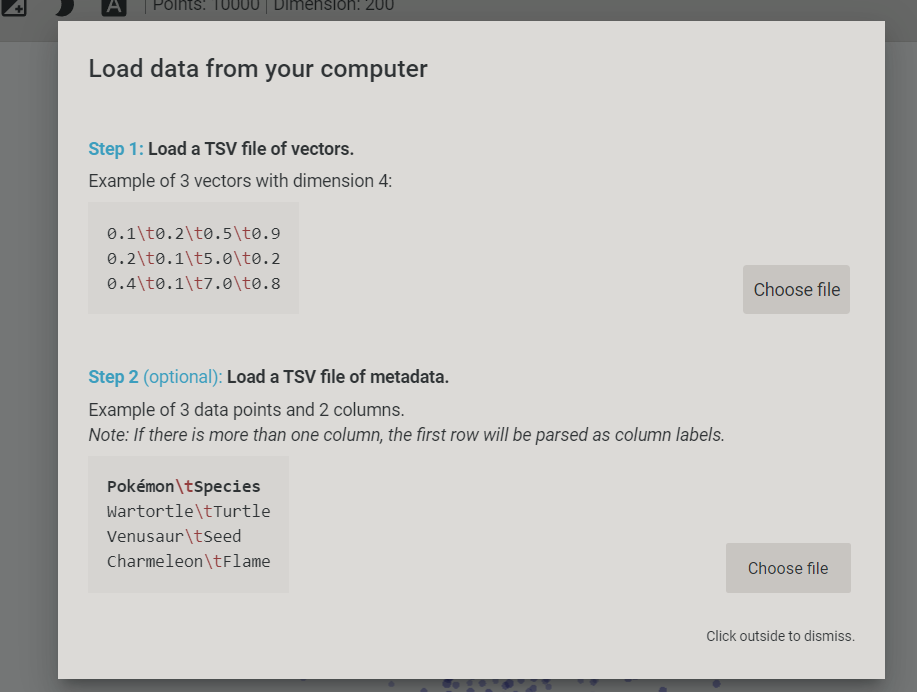

Looks pretty good!

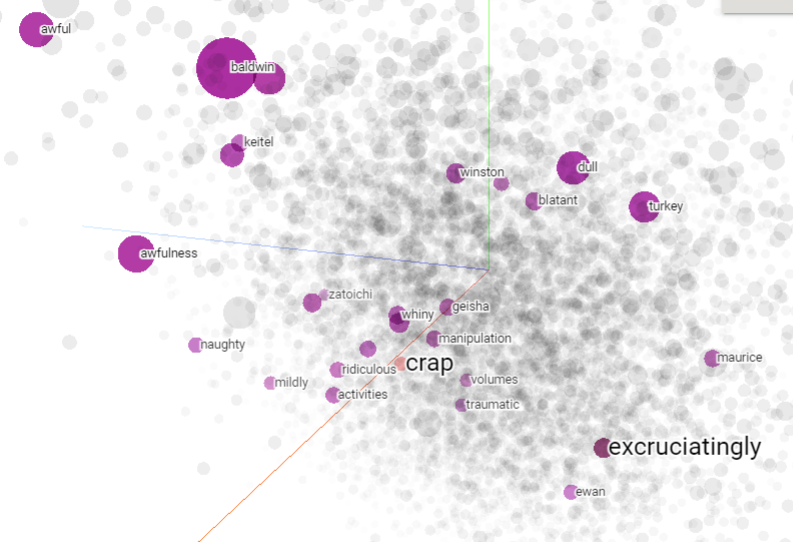